In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
# Extract ZIP file and list directories
zip_path = '/content/drive/MyDrive/B/Skin.zip'
extract_path = '/content/Skin'

print(f"Extracting {zip_path} to {extract_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed. Listing contents:")
for root, dirs, files in os.walk(extract_path):
    for dir_name in dirs:
        print(f"Directory: {os.path.join(root, dir_name)}")

Extracting /content/drive/MyDrive/B/Skin.zip to /content/Skin...
Extraction completed. Listing contents:
Directory: /content/Skin/Skin
Directory: /content/Skin/Skin/HAM10000_images_part_2
Directory: /content/Skin/Skin/HAM10000_images_part_1


In [ ]:
import pandas as pd

metadata = pd.read_csv("/content/Skin/Skin/HAM10000_metadata.csv")

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
image_id_to_label = dict(zip(metadata["image_id"], metadata["dx"]))

In [ ]:
import os

# List of directories containing images
image_folders = [
    "/content/Skin/Skin/HAM10000_images_part_1",
    "/content/Skin/Skin/HAM10000_images_part_2"
]

# Lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate through each folder
for folder in image_folders:
    for filename in os.listdir(folder):  # List all files in the folder

        image_id = filename.split(".")[0]  # Extract the image ID (remove file extension)
        if image_id in image_id_to_label:  # Check if the image ID exists in the label dictionary
            image_paths.append(os.path.join(folder, filename))  # Store the full image path
            labels.append(image_id_to_label[image_id])  # Store the corresponding label

# Print the number of images and labels
print(f"Number of images: {len(image_paths)}, Number of labels: {len(labels)}")

Number of images: 10015, Number of labels: 10015


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.8 MB/s eta 0:00:00


In [ ]:
# Import the necessary library
from datasets import Dataset

# Combine image paths and labels into a Hugging Face Dataset format
data = {"image": image_paths, "label": labels}
dataset = Dataset.from_dict(data)

# Display the first few rows of the dataset
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 10015
})


In [ ]:
# Get unique labels from the dataset
unique_labels = list(set(labels))

# Print the unique labels
print(f"Unique labels: {unique_labels}")

Unique labels: ['vasc', 'akiec', 'df', 'bcc', 'bkl', 'nv', 'mel']


In [ ]:
from datasets import ClassLabel

# Create a ClassLabel object
class_label = ClassLabel(names=unique_labels)

# Convert string labels to integer indices
dataset = dataset.map(lambda example: {'label': class_label.str2int(example['label'])})

# Set the 'label' column to ClassLabel type
dataset = dataset.cast_column('label', class_label)

Map:   0%|          | 0/10015 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10015 [00:00<?, ? examples/s]

In [ ]:
from datasets import Image
dataset = dataset.cast_column("image", Image())

In [ ]:
dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['vasc', 'akiec', 'df', 'bcc', 'bkl', 'nv', 'mel'], id=None)}

In [ ]:
from collections import Counter

# Count the frequency of each label
label_counts = Counter(dataset['label'])

# Print the label names and their corresponding counts
for idx, count in label_counts.items():
    print(f"Category: {dataset.features['label'].int2str(idx)}, Count: {count}")

Category: nv, Count: 6705
Category: mel, Count: 1113
Category: bcc, Count: 514
Category: bkl, Count: 1099
Category: akiec, Count: 327
Category: vasc, Count: 142
Category: df, Count: 115


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline


image_processor = AutoImageProcessor.from_pretrained(
    'Anwarkh1/Skin_Cancer-Image_Classification'
,use_fast=True)

image_processor

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

ViTImageProcessorFast {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "benign_keratosis-like_lesions",
    "1": "basal_cell_carcinoma",
    "2": "actinic_keratoses",
    "3": "vascular_lesions",
    "4": "melanocytic_Nevi",
    "5": "melanoma",
    "6": "dermatofibroma"
  },
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_size": 224,
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "actinic_keratoses": 2,
    "basal_cell_carcinoma": 1,
    "benign_keratosis-like_lesions": 0,
    "dermatofibroma": 6,
    "melanocytic_Nevi": 4,
    "

In [ ]:
# Label mapping (label2id and id2label) must match the model's preprocessor definition
# to ensure consistency between the dataset and model inputs/outputs.
# If a pretrained model does not define a label mapping, it must be manually defined.

label2id = image_processor.label2id
id2label = image_processor.id2label

# Print the extracted mappings
print("label2id mapping:", label2id)
print("id2label mapping:", id2label)

label2id mapping: {'benign_keratosis-like_lesions': 0, 'basal_cell_carcinoma': 1, 'actinic_keratoses': 2, 'vascular_lesions': 3, 'melanocytic_Nevi': 4, 'melanoma': 5, 'dermatofibroma': 6}
id2label mapping: {'0': 'benign_keratosis-like_lesions', '1': 'basal_cell_carcinoma', '2': 'actinic_keratoses', '3': 'vascular_lesions', '4': 'melanocytic_Nevi', '5': 'melanoma', '6': 'dermatofibroma'}


In [ ]:
from torchvision.transforms import Normalize
image_mean , image_std = image_processor.image_mean,image_processor.image_std
image_size = image_processor.size['height']
normalize = Normalize(mean=image_mean, std=image_std)

In [ ]:
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [ ]:
# Data Preprocessing and Data Augmentation

# Transformation for training data
train_tf = Compose([
    Resize((image_size, image_size)),  # Resize the image to the specified size (e.g., 224x224)
    RandomRotation(90),                # Randomly rotate the image by up to 90 degrees
    RandomAdjustSharpness(2),          # Randomly adjust image sharpness with a sharpness factor of 2
    RandomHorizontalFlip(0.5),         # Apply a horizontal flip with a 50% probability
    ToTensor(),                        # Convert the PIL image to a Tensor (pixel values range from 0 to 1)
    normalize                          # Normalize the image using `image_mean` and `image_std`
])

In [ ]:
val_tf = Compose([
    Resize((image_size, image_size)),  # Resize the image to the specified size (e.g., 224x224)
    ToTensor(),                        # Convert the PIL image to a Tensor (pixel values range from 0 to 1)
    normalize                          # Normalize the image using `image_mean` and `image_std`
])

In [ ]:
def train_transforms(examples):
    examples['pixel_values'] = [train_tf(image.convert("RGB")) for image in examples['image']]
    return examples


def val_transforms(examples):
    examples['pixel_values'] = [val_tf(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
# Split the dataset into training, validation, and test sets
train_test_split = dataset.train_test_split(test_size=0.2)  # 70% training, 20% test
train_val_split = train_test_split["train"].train_test_split(test_size=0.1)  # 10% validation from training data

# Assign the subsets
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]
test_dataset = train_test_split["test"]

# Print the dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 7210
Validation set size: 802
Test set size: 2003


In [ ]:
train_dataset.set_transform(train_transforms)
val_dataset.set_transform(val_transforms)
test_dataset .set_transform(val_transforms)

In [ ]:


sample = train_dataset[0]


print(sample)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BDFB1F93590>, 'label': 5, 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1.

In [ ]:
model = AutoModelForImageClassification.from_pretrained( 'Anwarkh1/Skin_Cancer-Image_Classification',
    label2id=label2id,
    id2label=id2label,
    num_labels=7,
    ignore_mismatched_sizes=True )

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [ ]:
model_checkpoint = 'Anwarkh1/Skin_Cancer-Image_Classification'
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}",                # Path to save the model, dynamically set
    remove_unused_columns=False,    # Whether to remove unused columns; default is False (keeps all columns)
    eval_strategy="epoch",          # Evaluation strategy: evaluate at the end of each epoch
    save_strategy="epoch",          # Save strategy: save the model at the end of each epoch
    learning_rate=3e-5,             # Learning rate: step size for updating model parameters during training
    lr_scheduler_type="cosine",     # Learning rate scheduler: "cosine" (cosine annealing), reduces LR gradually
    auto_find_batch_size=True,      # Automatically find an appropriate batch size based on available memory
    per_device_train_batch_size=64, # Training batch size per device (e.g., per GPU)
    per_device_eval_batch_size=64,  # Evaluation batch size per device
    weight_decay=0.1,               # Weight decay for preventing overfitting (L2 regularization)
    num_train_epochs=10,             # Total number of training epochs
    load_best_model_at_end=True,    # Load the best model at the end of training
    metric_for_best_model="accuracy", # Metric to determine the best model (here, accuracy)
    logging_strategy="epoch",       # Log loss at the end of each epoch
    report_to="none"                # Disable reporting to external systems (e.g., WandB, TensorBoard)
)

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00


In [ ]:
import evaluate

# Load the accuracy metric
metric = evaluate.load("accuracy")

# Define the evaluation function
# Assume our predicted results are stored in 'output'
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)  # Get the index of the highest probability for each sample
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)  # Calculate accuracy

# 'eval_pred.label_ids' contains the actual labels from the validation/test dataset

In [ ]:
import torch
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

<ipython-input-28-24bc35bb2a98>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:

import numpy as np
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.068800,0.537620,0.805486
2,0.422700,0.349825,0.884040
3,0.310300,0.243939,0.930175
4,0.244800,0.218151,0.932668
5,0.206800,0.175874,0.943890
6,0.170200,0.157979,0.951372
7,0.146900,0.151365,0.953865
8,0.129300,0.147368,0.951372
9,0.118300,0.149059,0.953865
10,0.117800,0.148862,0.953865


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9539
  eval_loss               =     0.1514
  eval_runtime            = 0:00:17.12
  eval_samples_per_second =     46.829
  eval_steps_per_second   =      0.759


In [ ]:
outputs = trainer.predict(test_dataset)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.13005419075489044, 'test_accuracy': 0.964053919121318, 'test_runtime': 46.9341, 'test_samples_per_second': 42.677, 'test_steps_per_second': 0.682}


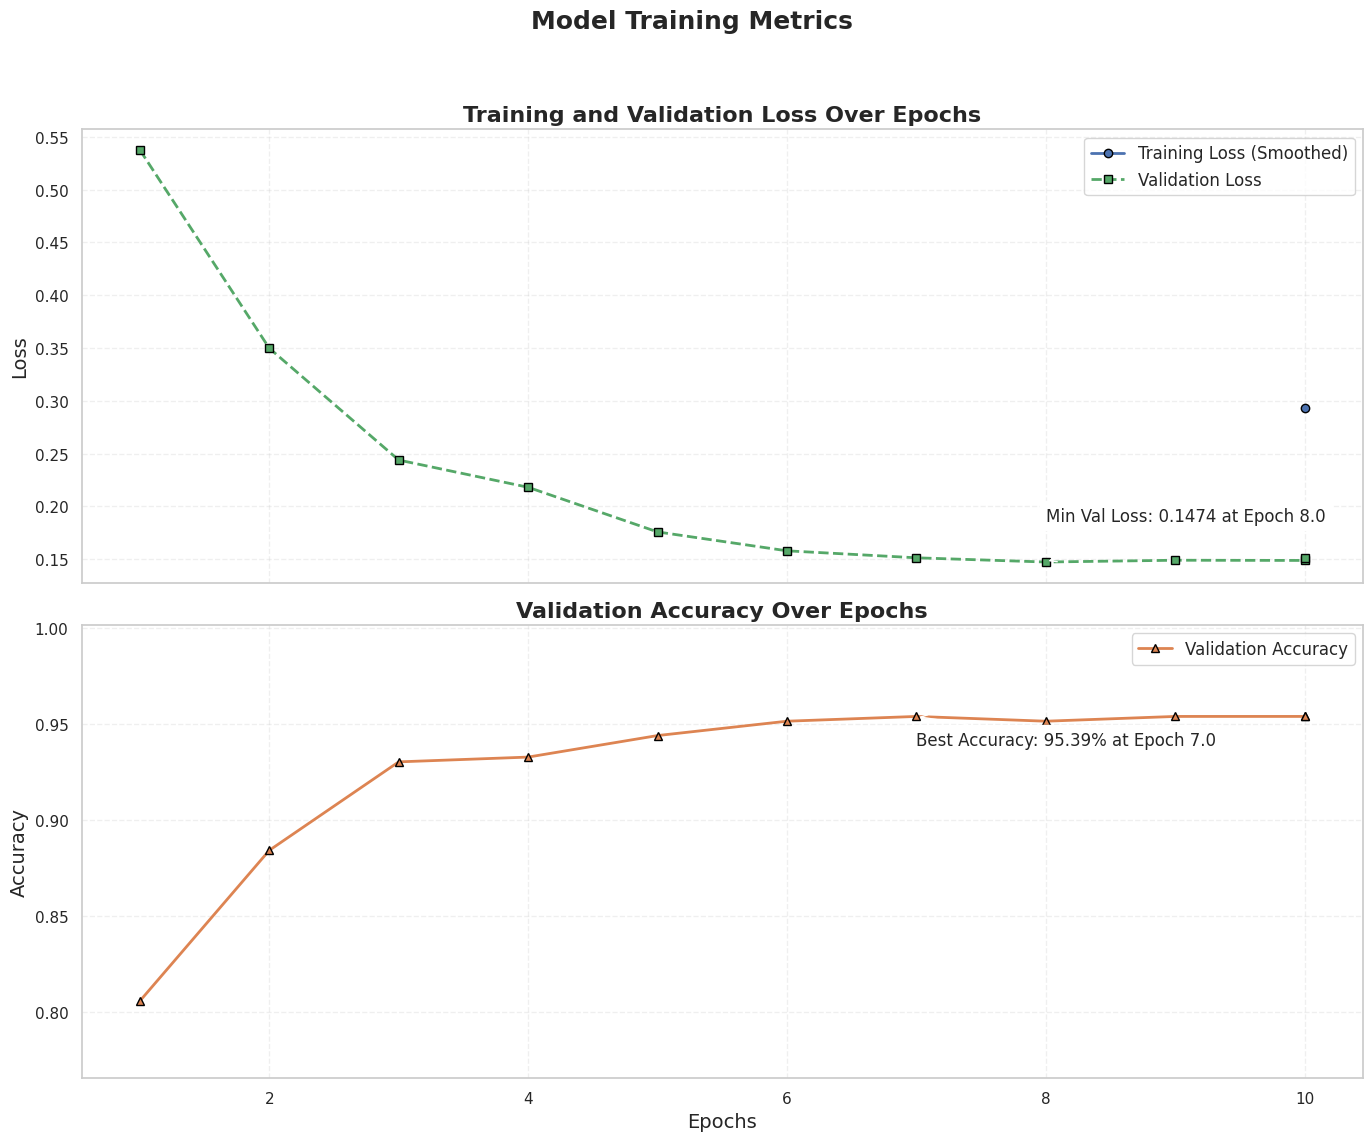

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Configure Matplotlib to display Chinese characters and handle negative signs
plt.rcParams['font.sans-serif'] = ['SimHei']  # Use SimHei font for Chinese characters
plt.rcParams['axes.unicode_minus'] = False    # Ensure minus signs are displayed correctly

# Initialize lists to store metrics
train_epochs = []
train_loss = []
eval_epochs = []
eval_loss = []
eval_accuracy = []

# Access the training history from the Trainer object
log_history = trainer.state.log_history  # Assign the log history to a variable

# Iterate through the log_history to extract metrics
for log in log_history:
    if "epoch" in log:
        current_epoch = log["epoch"]

        if "loss" in log:
            # Assuming training loss is logged multiple times per epoch (e.g., per batch)
            train_epochs.append(current_epoch)
            train_loss.append(log["loss"])

        if "eval_loss" in log:
            # Evaluation metrics are typically logged once per epoch
            eval_epochs.append(current_epoch)
            eval_loss.append(log["eval_loss"])

        if "eval_accuracy" in log:
            eval_accuracy.append(log["eval_accuracy"])

# Ensure that evaluation metrics have corresponding epochs
assert len(eval_epochs) == len(eval_loss) == len(eval_accuracy), "Mismatch in evaluation metrics lengths."

# Optional: Smooth training loss using a rolling average (e.g., window size of 10)
window_size = 10
if len(train_loss) >= window_size:
    train_loss_smooth = np.convolve(train_loss, np.ones(window_size)/window_size, mode='valid')
    train_epochs_smooth = train_epochs[window_size-1:]
else:
    train_loss_smooth = train_loss
    train_epochs_smooth = train_epochs

# Identify the epoch with the best validation accuracy
best_epoch = eval_epochs[np.argmax(eval_accuracy)]
best_accuracy = max(eval_accuracy)

# Create a color palette
palette = sns.color_palette("deep")

# Create subplots with shared x-axis
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# --- Subplot 1: Loss Curves ---
axes[0].plot(train_epochs_smooth, train_loss_smooth, label="Training Loss (Smoothed)",
             color=palette[0], linewidth=2, marker='o', markersize=6, markeredgecolor='black')
axes[0].plot(eval_epochs, eval_loss, label="Validation Loss",
             color=palette[2], linewidth=2, linestyle='--', marker='s', markersize=6, markeredgecolor='black')
axes[0].set_title("Training and Validation Loss Over Epochs", fontsize=16, fontweight="bold")
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.3)

# Optionally, add annotations to each training loss point
# for epoch, loss in zip(train_epochs_smooth, train_loss_smooth):
#     axes[0].text(epoch, loss, f"{loss:.4f}", fontsize=8, ha='center', va='bottom')

# Optionally, add annotations to each validation loss point
# for epoch, loss in zip(eval_epochs, eval_loss):
#     axes[0].text(epoch, loss, f"{loss:.4f}", fontsize=8, ha='center', va='bottom')

# Annotate the minimum validation loss
min_val_loss = min(eval_loss)
min_loss_epoch = eval_epochs[eval_loss.index(min_val_loss)]
axes[0].annotate(f"Min Val Loss: {min_val_loss:.4f} at Epoch {min_loss_epoch}",
                xy=(min_loss_epoch, min_val_loss),
                xytext=(min_loss_epoch, min_val_loss + (max(eval_loss)-min(eval_loss))*0.1),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=12, backgroundcolor='white')

# --- Subplot 2: Accuracy Curve ---
axes[1].plot(eval_epochs, eval_accuracy, label="Validation Accuracy",
             color=palette[1], linewidth=2, marker='^', markersize=6, markeredgecolor='black')
axes[1].set_title("Validation Accuracy Over Epochs", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_ylim([min(eval_accuracy) * 0.95, max(eval_accuracy) * 1.05])  # Adjust y-axis range
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.3)

# Optionally, add annotations to each validation accuracy point
# for epoch, acc in zip(eval_epochs, eval_accuracy):
#     axes[1].text(epoch, acc, f"{acc:.2%}", fontsize=8, ha='center', va='bottom')

# Annotate the best validation accuracy
axes[1].annotate(f"Best Accuracy: {best_accuracy:.2%} at Epoch {best_epoch}",
                xy=(best_epoch, best_accuracy),
                xytext=(best_epoch, best_accuracy - (max(eval_accuracy)-min(eval_accuracy))*0.1),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=12, backgroundcolor='white')

# Add an overall title
fig.suptitle("Model Training Metrics", fontsize=18, fontweight="bold")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Optional: Save the plot as a high-resolution image
# plt.savefig("model_training_metrics.png", dpi=300)

# Display the plot
plt.show()

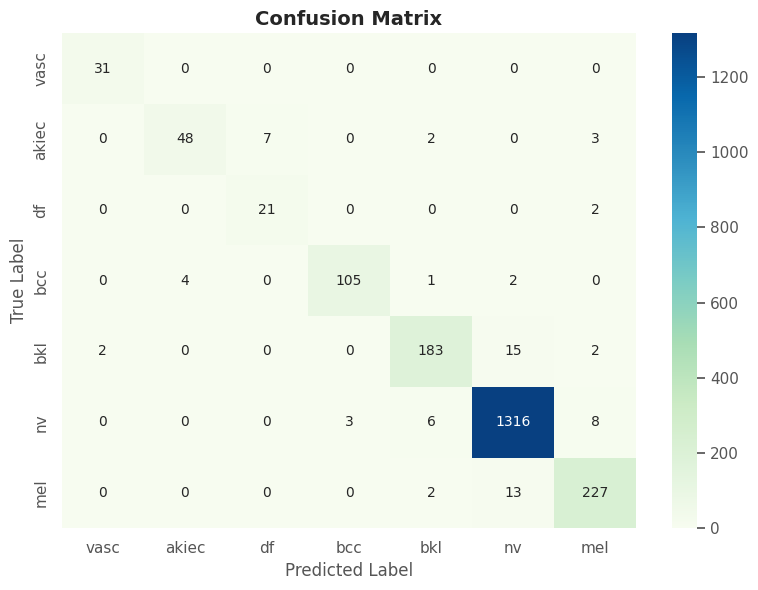

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Extract true labels and predicted labels
"""
If the dataset has been set with set_transform(), test_data becomes a streaming dataset:
Dataset({
    features: ['image', 'label'],
    num_rows: 7178
})

Using [example['label'] for example in test_data]:

- 'example' represents each row (sample) in the dataset.
- 'example['label']' retrieves the label of the current sample.
- The labels are then stored in a list.
"""
y_true = [example['label'] for example in test_dataset]  # Extract true labels from test_data
y_pred = np.argmax(outputs.predictions, axis=1)  # Get model predictions (index of the highest probability)

# 2. Get class label names
label_names = test_dataset.features['label'].names  # Retrieve the list of class label names

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot a well-styled confusion matrix
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="GnBu", cbar=True, xticklabels=label_names, yticklabels=label_names)

# Add title and labels
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

Classification Report:

              precision    recall  f1-score   support

        vasc       0.94      1.00      0.97        31
       akiec       0.92      0.80      0.86        60
          df       0.75      0.91      0.82        23
         bcc       0.97      0.94      0.95       112
         bkl       0.94      0.91      0.92       202
          nv       0.98      0.99      0.98      1333
         mel       0.94      0.94      0.94       242

    accuracy                           0.96      2003
   macro avg       0.92      0.93      0.92      2003
weighted avg       0.96      0.96      0.96      2003



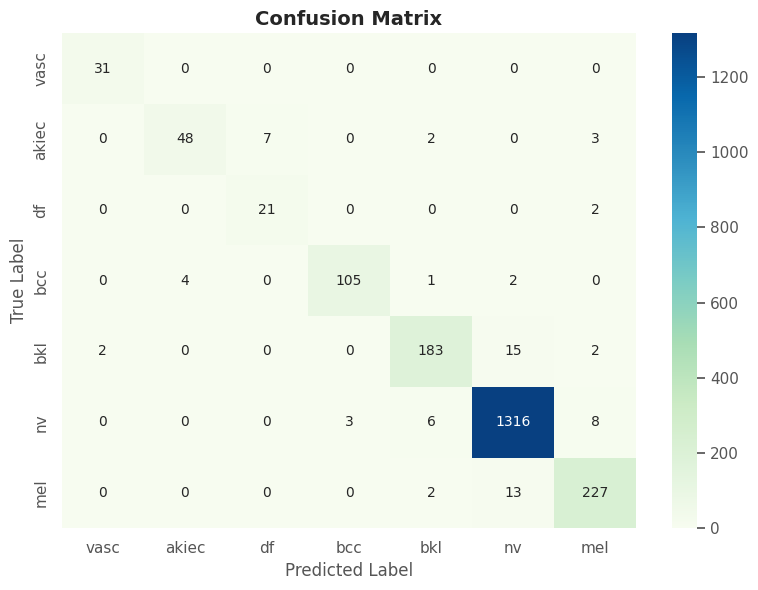

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Extract true labels and predicted labels
y_true = [example['label'] for example in test_dataset]  # Extract true labels from test_data
y_pred = np.argmax(outputs.predictions, axis=1)  # Get model predictions (index of the highest probability)

# 2. Get class label names
label_names = test_dataset.features['label'].names  # Retrieve the list of class label names

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_names))

# 5. Plot a well-styled confusion matrix
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="GnBu", cbar=True, xticklabels=label_names, yticklabels=label_names)

# Add title and labels
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

Classification Report:

              precision    recall  f1-score   support

        vasc       0.94      1.00      0.97        31
       akiec       0.92      0.80      0.86        60
          df       0.75      0.91      0.82        23
         bcc       0.97      0.94      0.95       112
         bkl       0.94      0.91      0.92       202
          nv       0.98      0.99      0.98      1333
         mel       0.94      0.94      0.94       242

    accuracy                           0.96      2003
   macro avg       0.92      0.93      0.92      2003
weighted avg       0.96      0.96      0.96      2003


Overall Metrics:
Accuracy: 0.9641
Precision: 0.9205
Recall: 0.9260
F1-score: 0.9212
AUC: AUC calculation not possible for this dataset.
Bias: 0.6655


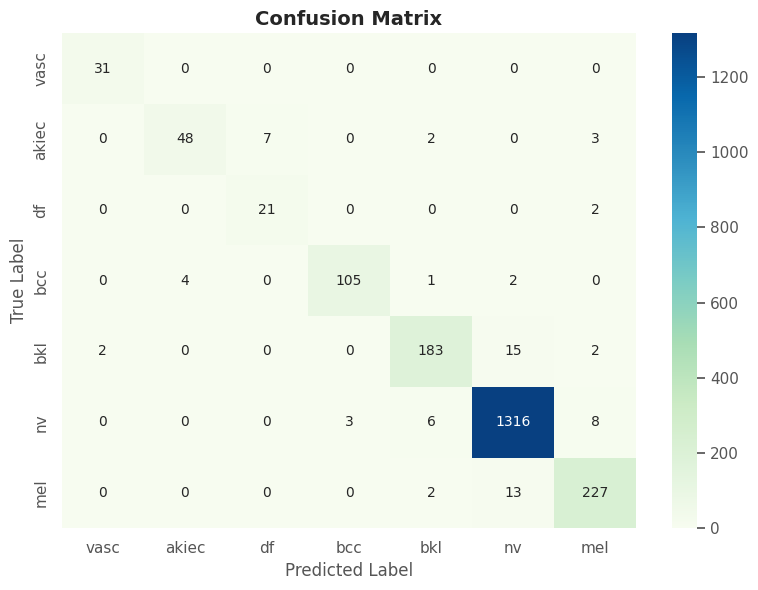

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)
import numpy as np

# 1. Extract true labels and predicted labels
y_true = [example['label'] for example in test_dataset]  # Extract true labels from test_data
y_pred = np.argmax(outputs.predictions, axis=1)  # Get model predictions (index of the highest probability)

# 2. Get class label names
label_names = test_dataset.features['label'].names  # Retrieve the list of class label names

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_names))

# 5. Compute overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # Macro: average across classes
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# AUC calculation (Only applicable for binary or one-vs-rest multi-class)
try:
    auc = roc_auc_score(y_true, outputs.predictions, multi_class='ovr')
except ValueError:
    auc = "AUC calculation not possible for this dataset."

# Bias calculation (Difference between accuracy and expected class balance)
bias = max(np.bincount(y_true)) / len(y_true)

# 6. Print overall metrics
print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc}")
print(f"Bias: {bias:.4f}")

# 7. Plot a well-styled confusion matrix
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="GnBu", cbar=True, xticklabels=label_names, yticklabels=label_names)

# Add title and labels
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()